# Exploratory Data Analysis (EDA) — arXiv Metadata Dataset

## Project Goal
Build a clean, high-quality document corpus from the arXiv metadata dataset (titles + abstracts + categories + dates) to support a **citation-aware RAG chatbot**.

## Short Description
This EDA focuses on:
- **Text quality** (abstract completeness and length)
- **Domain coverage** (category distribution)
- **Filtering strategy** (ML/NLP subset such as `cs.CL`, `cs.LG`, `cs.AI`)
- **Metadata readiness** (stable IDs/dates; optional fields like DOI/journal info)

> Note: For fast iteration, we analyze a sample (e.g., 10,000 rows). The same steps can later be run on the full dataset.


## Setup
Import libraries, set display options for text fields, and define run-time parameters.


In [3]:
# importing modules

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_columns", 12)

# Path from your file explorer: 
FILE_PATH = "../data/raw/arxiv-metadata-oai-snapshot.json"
NROWS = 10000
TARGET_CATS = ["cs.CL", "cs.LG", "cs.AI"]

# Loading only 10,000 rows to keep it fast
df = pd.read_json(FILE_PATH, lines=True, nrows=NROWS)

print(f"Data loaded successfully! Rows loaded: {len(df)}")


Data loaded successfully! Rows loaded: 10000


## 1. Dataset Overview
Load the dataset and inspect shape, columns.

In [8]:
df.shape

(10000, 14)

In [10]:
df.columns

Index(['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'],
      dtype='object')

In [12]:
df = pd.read_json(FILE_PATH, lines=True, nrows=NROWS)

df.shape
df.columns
df.head(3).T

,0,1,2
id,704.0001,704.0002,704.0003
submitter,Pavel Nadolsky,Louis Theran,Hongjun Pan
authors,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",Ileana Streinu and Louis Theran,Hongjun Pan
title,Calculation of prompt diphoton production cross sections at Tevatron and\n LHC energies,Sparsity-certifying Graph Decompositions,The evolution of the Earth-Moon system based on the dark matter field\n fluid model
comments,"37 pages, 15 figures; published version",To appear in Graphs and Combinatorics,"23 pages, 3 figures"
journal-ref,"Phys.Rev.D76:013009,2007",None,None
doi,10.1103/PhysRevD.76.013009,None,None
report-no,ANL-HEP-PR-07-12,None,None
categories,hep-ph,math.CO cs.CG,physics.gen-ph
license,None,http://arxiv.org/licenses/nonexclusive-distrib/1.0/,None


## Quick preview of RAG-relevant fields.

In [15]:
df[["id", "title", "categories", "abstract", "update_date"]].head(3)

,id,title,categories,abstract,update_date
0,704.0001,Calculation of prompt diphoton production cross sections at Tevatron and\n LHC energies,hep-ph,A fully differential calculation in perturbative quantum chromodynamics is\npresented for the ...,2008-11-26
1,704.0002,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use\nit obtain a char...",2008-12-13
2,704.0003,The evolution of the Earth-Moon system based on the dark matter field\n fluid model,physics.gen-ph,The evolution of Earth-Moon system is described by the dark matter field\nfluid model proposed...,2008-01-13


## 2. Data Quality Checks
Assess completeness and reliability for RAG. Check:
- Missing values
- Duplicate IDs
- Basic text cleanup
- Very short abstracts (low retrieval value)


In [18]:
df.info()

missing = df.isnull().sum().sort_values(ascending=False)
missing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  float64
 1   submitter       10000 non-null  object 
 2   authors         10000 non-null  object 
 3   title           10000 non-null  object 
 4   comments        8862 non-null   object 
 5   journal-ref     5433 non-null   object 
 6   doi             6363 non-null   object 
 7   report-no       883 non-null    object 
 8   categories      10000 non-null  object 
 9   license         712 non-null    object 
 10  abstract        10000 non-null  object 
 11  versions        10000 non-null  object 
 12  update_date     10000 non-null  object 
 13  authors_parsed  10000 non-null  object 
dtypes: float64(1), object(13)
memory usage: 1.1+ MB


license           9288
report-no         9117
journal-ref       4567
doi               3637
comments          1138
id                   0
submitter            0
authors              0
title                0
categories           0
abstract             0
versions             0
update_date          0
authors_parsed       0
dtype: int64

In [20]:
# Duplicate check (id should be unique)
df["id"].duplicated().sum()


0

In [22]:
# Light text cleanup (safe)
for col in ["title", "abstract", "categories", "authors"]:
    df[col] = df[col].astype(str).str.strip()


In [24]:
# Very short abstracts (characters)
df["abstract_len_chars"] = df["abstract"].str.len()
df[df["abstract_len_chars"] < 50].shape


(17, 15)

## 3. Univariate Analysis
Analyze single variables that matter most for RAG:
- Abstract length (chunking decision)
- Category distribution (filtering decision)
- Update date (recency/ranking decision)


## 3.1 Abstract length distribution

In [28]:
df["abstract_len_words"] = df["abstract"].str.split().apply(len)
df["abstract_len_words"].describe()

count    10000.000000
mean       121.317400
std         63.171115
min          2.000000
25%         76.000000
50%        109.000000
75%        157.000000
max        338.000000
Name: abstract_len_words, dtype: float64

### Histogram Graph that shows Abstract Length Distribution for Words. Each bar represents how many papers fall into a specific word-count range.

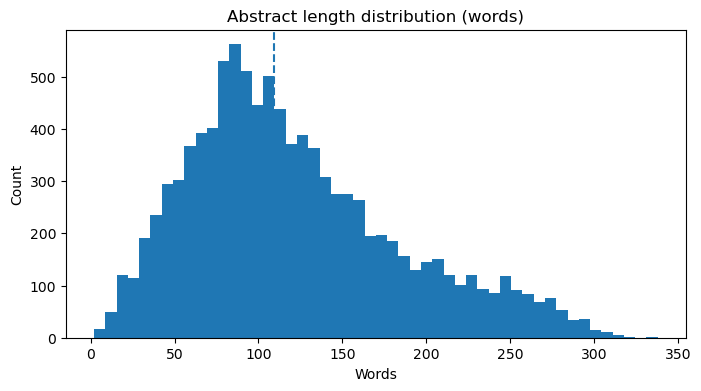

In [38]:
plt.figure(figsize=(8,4))
plt.hist(df["abstract_len_words"], bins=50)
plt.title("Abstract length distribution (words)")
plt.xlabel("Words")
plt.ylabel("Count")
plt.axvline(df["abstract_len_words"].median(), linestyle="--") # verticle line for teh median

plt.show()


### Abstract Length Distribution (Words)

The histogram above shows the distribution of abstract lengths, measured in number of words, across the arXiv paper sample.

**Key observations:**
- Most abstracts fall between approximately **60 and 150 words**, indicating a consistent abstract length across the dataset.
- The distribution is **right-skewed**, with a small number of papers having longer abstracts extending beyond 200 words.
- Very short abstracts (below ~40 words) are rare and likely represent low-information or incomplete entries.
- The maximum abstract length observed is around **330 words**, confirming that abstracts are concise summaries rather than full documents.

**Implications for RAG design:**
- Abstracts are well-suited for semantic chunking, typically requiring **one to two chunks per document**.
- A chunk size in the range of **150–300 tokens** is appropriate for embedding and retrieval.
- Extremely short abstracts can be excluded during preprocessing to improve retrieval quality.

This analysis confirms that the dataset’s text structure is suitable for building a retrieval-augmented generation (RAG) system.


## 3.2 Category distribution

In [41]:
df["categories_list"] = df["categories"].str.split()
cat_counts = df["categories_list"].explode().value_counts()

cat_counts.head(20)


categories_list
astro-ph              2064
hep-th                 996
hep-ph                 901
quant-ph               672
gr-qc                  558
cond-mat.stat-mech     445
cond-mat.mtrl-sci      444
math.MP                436
math-ph                436
cond-mat.str-el        419
cond-mat.mes-hall      391
math.AG                313
nucl-th                277
cond-mat.other         269
cond-mat.supr-con      249
cond-mat.soft          235
math.PR                228
hep-ex                 224
math.DG                209
math.CO                205
Name: count, dtype: int64

### Graph that represents Category Distribution. Each bar represents how many times a category appears across all papers (papers can belong to multiple categories).


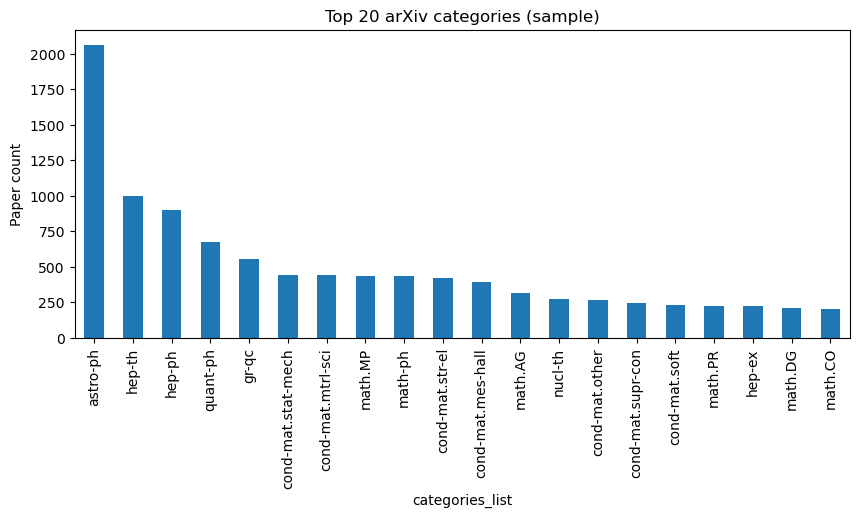

In [44]:
plt.figure(figsize=(10,4))
cat_counts.head(20).plot(kind="bar")
plt.title("Top 20 arXiv categories (sample)")
plt.ylabel("Paper count")
plt.show()


### Category Distribution (Top 20)

The bar chart above shows the distribution of the top 20 arXiv subject categories in the sampled dataset. Since papers can belong to multiple categories, counts represent the total number of category assignments rather than unique papers.

**Key observations:**
- The dataset is heavily dominated by physics-related categories, with `astro-ph`, `hep-th`, and `hep-ph` appearing most frequently.
- Computer science and AI-related categories are comparatively underrepresented in this sample.
- The distribution follows a long-tail pattern, where a small number of categories account for a large portion of the dataset.

**Implications for RAG design:**
- Without domain filtering, retrieval results may be biased toward physics topics.
- For AI- or ML-focused question answering, restricting the corpus to categories such as `cs.AI`, `cs.LG`, and `cs.CL` can significantly improve relevance.
- Category-based filtering should be applied during preprocessing to ensure balanced and domain-specific retrieval.

This analysis highlights the importance of metadata-aware corpus selection for building an effective retrieval-augmented generation (RAG) system.


### 3.3 Date distribution

In [49]:
df["update_date"] = pd.to_datetime(df["update_date"], errors="coerce")
year_counts = df["update_date"].dt.year.value_counts().sort_index()
year_counts.tail(10)


update_date
2016    180
2017     46
2018     28
2019    129
2020     18
2021     14
2022     14
2023      9
2024      6
2025     10
Name: count, dtype: int64

### Graph that represents Date Distribution. Each point on the line represents how many papers in the sample were last updated in a given year.

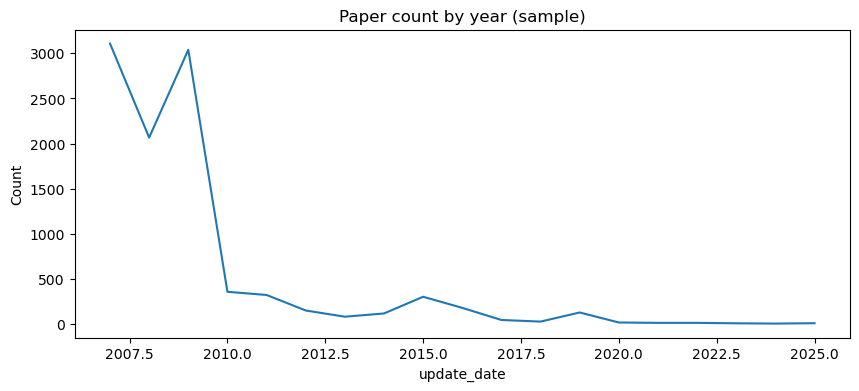

In [52]:
plt.figure(figsize=(10,4))
year_counts.plot()
plt.title("Paper count by year (sample)")
plt.ylabel("Count")
plt.show()


### Paper Update Year Distribution

The line plot above shows the distribution of papers by their last update year within the sampled arXiv dataset.

**Key observations:**
- The majority of papers in the sample were updated between **2007 and 2009**, indicating a strong concentration of older publications.
- There is a sharp decline in paper counts after 2010, with relatively few papers updated in more recent years.
- Very few records appear after 2020, reflecting both the chronological ordering of the dataset and the limited sample size.

**Implications for RAG design:**
- Temporal bias in the dataset can affect retrieval relevance, especially for queries related to recent research trends.
- Filtering or weighting documents by update year can help prioritize more recent and relevant content.
- Date metadata can serve as an additional ranking signal during retrieval or reranking.

This analysis highlights the importance of incorporating temporal awareness when constructing a retrieval-augmented generation (RAG) pipeline.


## 4. Bivariate Analysis
For metadata + text datasets, bivariate analysis works best using engineered numeric features:
- abstract_len_words
- num_authors
- has_doi
- year


### 4.1 Create helper features

In [58]:
df["num_authors"] = df["authors"].str.split(",").apply(len)
df["has_doi"] = df["doi"].notna().astype(int)
df["year"] = df["update_date"].dt.year


### 4.2 Example relationship Scatter plots/summaries

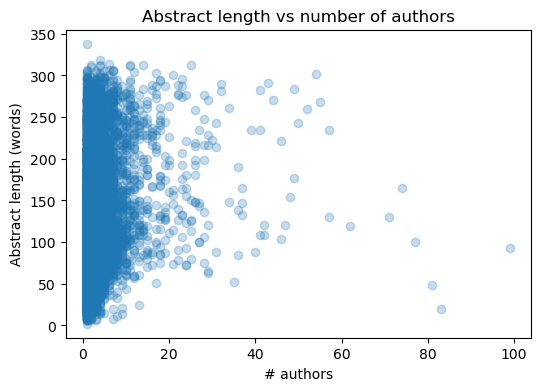

In [61]:
plt.figure(figsize=(6,4))
plt.scatter(df["num_authors"], df["abstract_len_words"], alpha=0.25)
plt.title("Abstract length vs number of authors")
plt.xlabel("# authors")
plt.ylabel("Abstract length (words)")
plt.show()


In [63]:
df.groupby("has_doi")["abstract_len_words"].describe()


,count,mean,std,min,25%,50%,75%,max
has_doi,,,,,,,,
0,3637.0,101.845752,58.168396,5.0,57.0,91.0,135.0,312.0
1,6363.0,132.447116,63.225836,2.0,85.0,119.0,170.0,338.0


### Bivariate Analysis: Abstract Length Relationships

This section explores relationships between abstract length and selected metadata features.

#### Abstract Length vs. Number of Authors
The scatter plot shows abstract length plotted against the number of authors per paper.

**Observations:**
- Most papers have fewer than 10 authors, forming a dense cluster.
- Abstract length varies widely across all author counts.
- No strong correlation is observed between the number of authors and abstract length.
- Papers with many authors do not consistently have longer abstracts, suggesting abstract length is governed by publication conventions rather than collaboration size.

#### Abstract Length by DOI Availability
The table summarizes abstract length statistics grouped by DOI presence.

**Observations:**
- Papers with a DOI have longer abstracts on average compared to papers without a DOI.
- Both the mean and median abstract lengths are higher for DOI-associated papers.
- Papers without DOIs tend to have shorter and more variable abstracts.

**Implications for RAG design:**
- Abstract chunking strategies do not need to account for author count.
- DOI presence can serve as a useful quality signal for filtering or reranking documents.
- Combining textual and metadata-based signals improves corpus quality and retrieval relevance.


## 5. Correlation Analysis
Correlation is meaningful only on numeric features. Here we correlate engineered features.


In [68]:
num_cols = ["abstract_len_words", "abstract_len_chars", "num_authors", "has_doi", "year"]
corr = df[num_cols].corr()
corr


,abstract_len_words,abstract_len_chars,num_authors,has_doi,year
abstract_len_words,1.000000,0.990637,0.201302,0.233049,0.067068
abstract_len_chars,0.990637,1.000000,0.192777,0.240047,0.063514
num_authors,0.201302,0.192777,1.000000,0.166392,0.061705
has_doi,0.233049,0.240047,0.166392,1.000000,0.277772
year,0.067068,0.063514,0.061705,0.277772,1.000000


### Correlation Analysis

This above table examines correlations between engineered numeric features to understand their relationships and potential redundancy.

The correlation heatmap visualizes pairwise Pearson correlation coefficients among the following features:
- Abstract length (words)
- Abstract length (characters)
- Number of authors
- DOI presence
- Update year


### Below is the correlation Analysis heatmap that engineered numeric features. Visualizes these correlations using a heatmap to make relationships easier to interpret.

Correlation values range from -1 to +1:

### +1 → strong positive relationship
### 0 → no relationship
### -1 → strong negative relationship

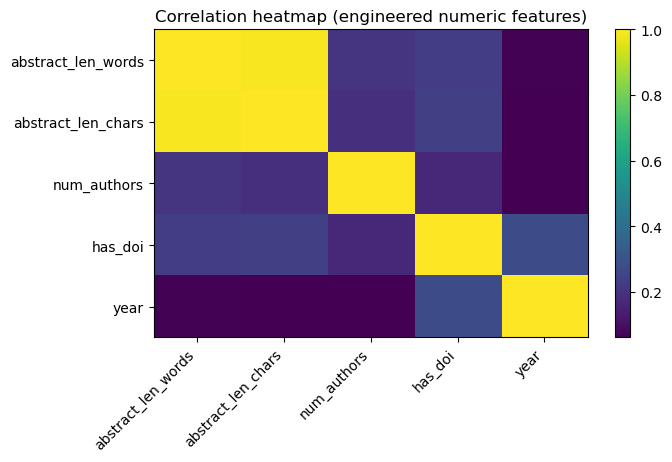

In [71]:
plt.figure(figsize=(7,4))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation heatmap (engineered numeric features)")
plt.colorbar()
plt.show()


### Correlation Heatmap Summary

The heatmap shows correlations between engineered numeric features in the dataset.

- Abstract length measured in words and characters is **highly correlated**, confirming they represent the same information.
- Abstract length has **weak correlation** with the number of authors, indicating collaboration size does not strongly affect abstract length.
- Papers with a DOI tend to have **slightly longer abstracts**, suggesting DOI presence may act as a quality signal.
- Abstract length shows **minimal correlation** with publication year, indicating stable abstract-writing conventions over time.
- DOI presence is **moderately correlated** with year, reflecting increased DOI adoption in recent publications.

Overall, the features show low redundancy (aside from length measures) and are suitable for use in a retrieval-augmented generation (RAG) pipeline.


## 6. Key Insights from EDA
Summarize key findings and how they affect RAG design.

### What I learned
- Core RAG fields (`id`, `title`, `categories`, `abstract`, `update_date`) are highly complete in the sample.
- Abstract lengths are typically sufficient for semantic retrieval and chunking.
- Category distribution is skewed, so filtering to ML/NLP categories improves relevance.
- Very short abstracts are rare and can be excluded to reduce noise.

### What I will do next (RAG-driven decisions)
1. Filter to ML/NLP categories (e.g., `cs.CL`, `cs.LG`, `cs.AI`).
2. Remove very short abstracts.
3. Keep stable metadata fields for citations (`id`, `title`, `categories`, `update_date`).
4. Use abstract-length stats to choose chunk size and overlap.


## 6.1 Filter ML/NLP subset (actual corpus)

In [85]:
mask = df["categories"].apply(lambda x: any(c in x.split() for c in TARGET_CATS))
df_ml = df[mask].copy()

df_ml.shape
df_ml[["id", "title", "categories", "abstract"]].head(3)


,id,title,categories,abstract
46,704.0047,Intelligent location of simultaneously active acoustic emission sources:\n Part I,cs.NE cs.AI,"The intelligent acoustic emission locator is described in Part I, while Part\nII discusses blind..."
49,704.0050,Intelligent location of simultaneously active acoustic emission sources:\n Part II,cs.NE cs.AI,"Part I describes an intelligent acoustic emission locator, while Part II\ndiscusses blind source..."
303,704.0304,The World as Evolving Information,cs.IT cs.AI math.IT q-bio.PE,"This paper discusses the benefits of describing the world as information,\nespecially in the stu..."


## drop short abstracts in filtered set:

In [88]:
df_ml = df_ml[df_ml["abstract"].str.len() >= 50].copy()
df_ml.shape


(76, 20)

## save data in processed folder under data. 
creating:

1. A general cleaned ML/NLP dataset

2. A RAG-ready corpus optimized for retrieval

In [94]:
# General cleaned ML/NLP dataset (analysis, reuse, experiments)
df_ml.to_csv("../data/processed/arxiv_ml_nlp_clean.csv", index=False)

# RAG-ready corpus (embedding, chunking, retrieval)
df_ml.to_csv("../data/processed/arxiv_ml_nlp_rag_corpus.csv", index=False)


### Saving Processed Datasets

Two processed versions of the ML/NLP subset were saved to support different downstream use cases:

- **arxiv_ml_nlp_clean.csv**  
  A cleaned and filtered ML/NLP dataset suitable for exploratory analysis, experimentation, and reuse.

- **arxiv_ml_nlp_rag_corpus.csv**  
  A RAG-ready corpus intended for embedding generation, chunking, and document retrieval in the Ask-My-Docs RAG chatbot.

Both datasets share the same core content but serve distinct roles in the project pipeline.


## Create a Data Schema.

In [97]:
# -----------------------------
# Data Schema for Processed ML/NLP Dataset
# -----------------------------

schema = pd.DataFrame({
    "column_name": df_ml.columns,
    "data_type": df_ml.dtypes.astype(str),
    "non_null_count": df_ml.notnull().sum().values,
    "null_count": df_ml.isnull().sum().values
})

schema


,column_name,data_type,non_null_count,null_count
id,id,float64,76,0
submitter,submitter,object,76,0
authors,authors,object,76,0
title,title,object,76,0
comments,comments,object,59,17
journal-ref,journal-ref,object,16,60
doi,doi,object,8,68
report-no,report-no,object,2,74
categories,categories,object,76,0
license,license,object,5,71


### Data Schema (Processed ML/NLP Dataset)

The table above documents the schema of the final processed ML/NLP dataset (`df_ml`) after filtering and cleaning.

For each column, the schema captures:
- **Column name** used in the dataset
- **Data type** after preprocessing and feature engineering
- **Non-null count** indicating data completeness
- **Null count** highlighting missing metadata fields

Core text fields such as `title`, `abstract`, and `categories` are fully populated, ensuring reliable downstream analysis and retrieval.  
Several optional metadata fields (`doi`, `journal-ref`, `license`) contain missing values, which is expected in arXiv submissions and does not impact the RAG pipeline.

All engineered features (`abstract_len_words`, `num_authors`, `has_doi`, `year`) contain no missing values, confirming the dataset is consistent and suitable for embedding generation, retrieval, and experimentation.


In [101]:
column_descriptions = {
    "id": "arXiv paper identifier",
    "title": "Paper title",
    "authors": "Author names as a string",
    "abstract": "Abstract text used for retrieval",
    "categories": "arXiv subject categories",
    "abstract_len_words": "Number of words in abstract",
    "abstract_len_chars": "Number of characters in abstract",
    "num_authors": "Number of authors",
    "has_doi": "Whether DOI is present (0/1)",
    "year": "Publication/update year"
}

schema["description"] = schema["column_name"].map(column_descriptions)
schema


,column_name,data_type,non_null_count,null_count,description
id,id,float64,76,0,arXiv paper identifier
submitter,submitter,object,76,0,NaN
authors,authors,object,76,0,Author names as a string
title,title,object,76,0,Paper title
comments,comments,object,59,17,NaN
journal-ref,journal-ref,object,16,60,NaN
doi,doi,object,8,68,NaN
report-no,report-no,object,2,74,NaN
categories,categories,object,76,0,arXiv subject categories
license,license,object,5,71,NaN


### Enhanced Data Schema (Documented ML/NLP Dataset)

The table above presents the final data schema for the processed ML/NLP dataset, augmented with human-readable column descriptions.

For each feature, the schema includes:
- **Column name** used in the dataset
- **Data type** after preprocessing and feature engineering
- **Non-null and null counts** to assess data completeness
- **Description** explaining the semantic meaning and intended use of the field

Core textual fields such as `title`, `abstract`, and `categories` are fully populated and form the foundation of the retrieval corpus.  
Engineered features (`abstract_len_words`, `num_authors`, `has_doi`, `year`) provide structured signals for analysis, ranking, and RAG optimization.

Several optional metadata fields (`doi`, `journal-ref`, `license`) are sparsely populated, which is expected for arXiv submissions and does not impact downstream retrieval or modeling workflows.

This documented schema serves as a data contract for analysis, experimentation, and deployment in the Ask-My-Docs RAG system.


### Save the schema

In [109]:
schema.to_csv("../data/processed/arxiv_ml_nlp_schema.csv", index=False)
